In [ ]:
#Installing dependencies
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = input()

GOOG


In [ ]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-06-27,56.067001,56.591801,55.181000,55.199001,55.199001,25878000
2018-06-28,55.104500,56.115501,54.800499,55.710999,55.710999,21448000
2018-06-29,56.000000,56.411350,55.750000,55.782501,55.782501,26302000
2018-07-02,54.950001,56.400002,54.689999,56.373001,56.373001,24346000
2018-07-03,56.791000,56.791000,55.000999,55.144501,55.144501,13580000


In [ ]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-21,123.235001,123.410004,120.860001,121.260002,121.260002,22612000
2023-06-22,120.660004,123.934998,119.599998,123.870003,123.870003,20781900
2023-06-23,122.040001,123.440002,121.860001,123.019997,123.019997,29542900
2023-06-26,121.466003,122.720001,118.989998,119.089996,119.089996,23135600
2023-06-27,117.839996,119.230003,116.910004,118.885002,118.885002,12637167


In [ ]:
len(data)

1258

In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,90.851332,91.917798,89.880775,90.917601,90.917601,3.033558e+07
std,30.148899,30.452321,29.823656,30.127701,30.127701,1.318003e+07
min,48.695000,50.176998,48.505501,48.811001,48.811001,6.936000e+06
25%,61.376625,61.938374,60.730124,61.269625,61.269625,2.197910e+07
50%,88.085251,88.996002,87.083000,88.155003,88.155003,2.705125e+07
75%,115.505749,117.148127,114.290003,115.469503,115.469503,3.418700e+07
max,151.863495,152.100006,149.887497,150.709000,150.709000,1.241400e+08


In [ ]:
opn = data[['Open']]

<Axes: xlabel='Date'>

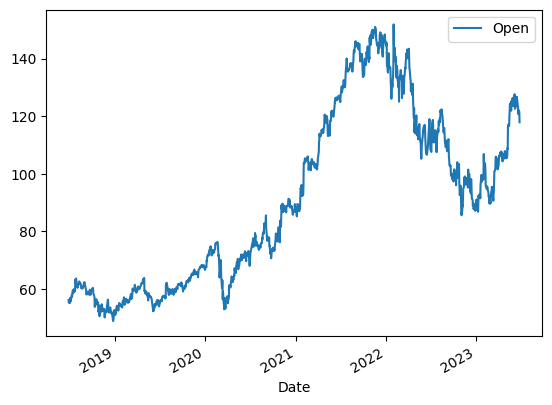

In [ ]:
opn.plot()

In [ ]:
ds = opn.values

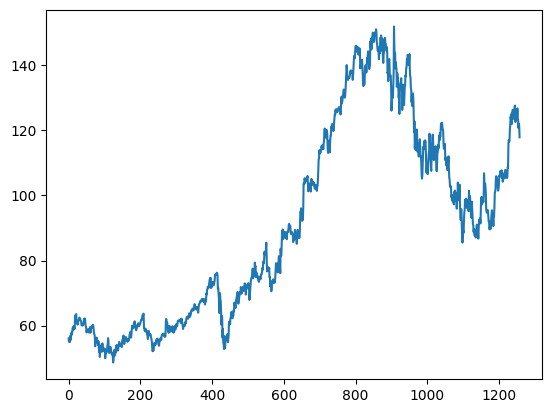

In [ ]:
plt.plot(ds)

In [ ]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [ ]:
len(ds_scaled), len(ds)

(1258, 1258)

In [ ]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [ ]:
train_size,test_size

(880, 378)

In [ ]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [ ]:
len(ds_train),len(ds_test)

(880, 378)

In [ ]:
#creating dataset in time series for LSTM model
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [ ]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [ ]:
X_train.shape,y_train.shape

((779, 100), (779,))

In [ ]:
X_test.shape, y_test.shape

((277, 100), (277,))

In [ ]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
13/13 [==============================] - 11s 326ms/step - loss: 0.0616 - val_loss: 0.0182
Epoch 2/100
13/13 [==============================] - 4s 286ms/step - loss: 0.0095 - val_loss: 0.0084
Epoch 3/100
13/13 [==============================] - 3s 202ms/step - loss: 0.0024 - val_loss: 0.0107
Epoch 4/100
13/13 [==============================] - 3s 208ms/step - loss: 0.0018 - val_loss: 0.0076
Epoch 5/100
13/13 [==============================] - 3s 210ms/step - loss: 0.0016 - val_loss: 0.0063
Epoch 6/100
13/13 [==============================] - 3s 237ms/step - loss: 0.0015 - val_loss: 0.0052
Epoch 7/100
13/13 [==============================] - 3s 252ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 8/100
13/13 [==============================] - 2s 193ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 9/100
13/13 [==============================] - 3s 212ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 10/100
13/13 [==============================] - 3s 194ms/step - loss: 0.0013 - val_l

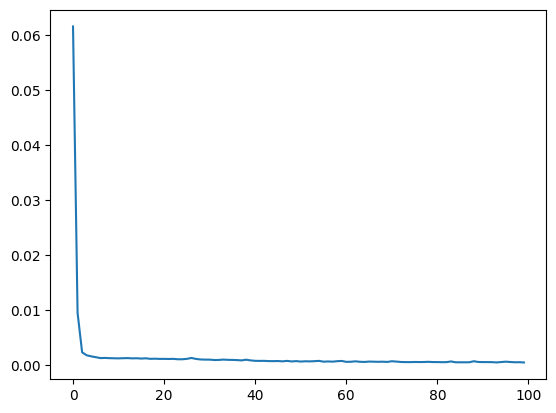

In [ ]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [ ]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 37ms/step


In [ ]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

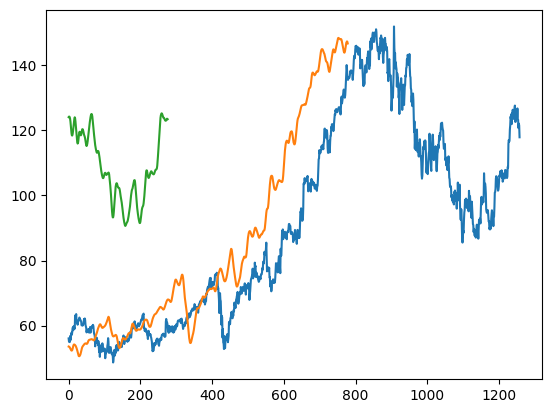

In [ ]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [ ]:
type(train_predict)

numpy.ndarray

In [ ]:
test = np.vstack((train_predict,test_predict))

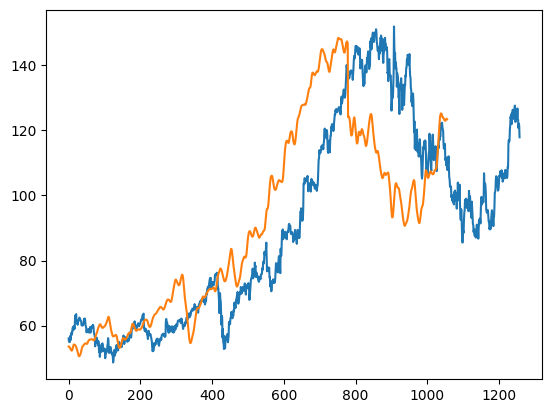

In [ ]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [ ]:
len(ds_test)

378

In [ ]:
#Getting the last 100 days records
fut_inp = ds_test[len(ds_test)-101:]

In [ ]:
fut_inp = fut_inp.reshape(1,-1)

In [ ]:
tmp_inp = list(fut_inp)

In [ ]:
fut_inp.shape

(1, 101)

In [ ]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [ ]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
print(lst_output)

[[0.7183648943901062], [0.7157962918281555], [0.7150953412055969], [0.7161937952041626], [0.7187899351119995], [0.7225517630577087], [0.7271936535835266], [0.7324935793876648], [0.7382786870002747], [0.7444202899932861], [0.7508149743080139], [0.7573732733726501], [0.7640166282653809], [0.7706711292266846], [0.7772657871246338], [0.7837328314781189], [0.7900142073631287], [0.7960522770881653], [0.8018002510070801], [0.8072174787521362], [0.8122738599777222], [0.8169434666633606], [0.8212137818336487], [0.8250803351402283], [0.8285475373268127], [0.8316255807876587], [0.8343338370323181], [0.8366962671279907], [0.8387375473976135], [0.8404940366744995]]


In [ ]:
len(ds_scaled)

1258

In [ ]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

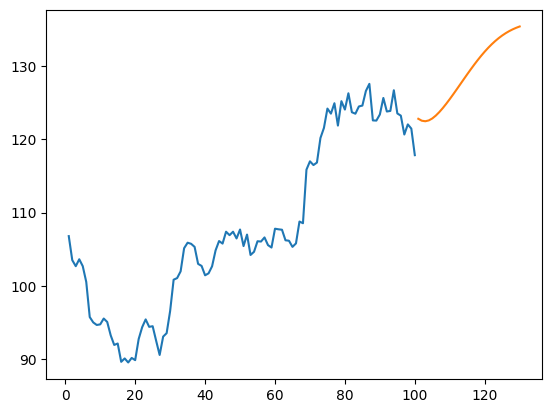

In [ ]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[len(ds_scaled)-100:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [ ]:
ds_new = ds_scaled.tolist()

In [ ]:
len(ds_new)

1258

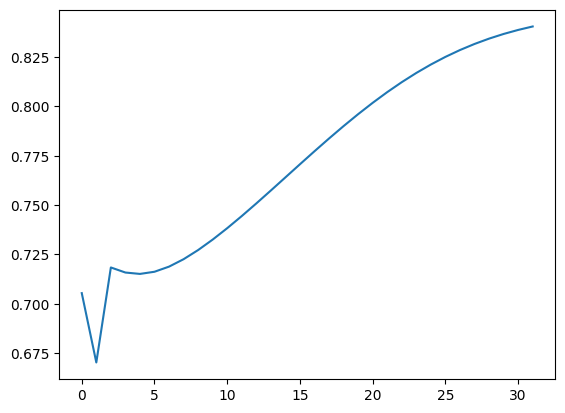

In [ ]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[len(ds_new)-32:])

In [ ]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

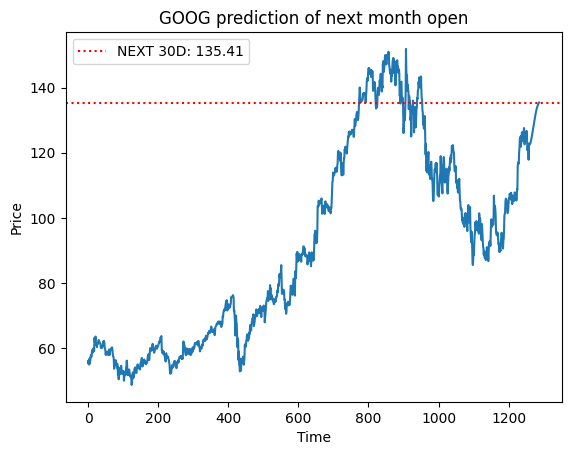

In [ ]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.savefig("final.png")
plt.legend()

In [ ]:
model.save("Stock.h5")

In [ ]:
import tensorflow as tf

In [ ]:
model_name = tf.keras.models.load_model("Stock.h5")

In [ ]:
model_name.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
input = model.input

In [ ]:
import yfinance as yf

ticker_symbol = "AAPL"  # Replace with your desired ticker symbol
data = yf.download(ticker_symbol, start="2023-01-01", end="2023-07-01")


[*********************100%***********************]  1 of 1 completed
